# Force fields


## Bonded and non-bonded interactions

Even with all the approximations and optimizations of the last hundred years, first principles quantum chemical calculations are still very resource demanding, even for quite small systems. The upper limit for a geometry optimization is around a thousand atoms and a dynamics simulation is only possible for systems of a few hundred atoms, and even then only for very short time scales. This means that unless new approximations are introduced, many systems that are of interest will be far beyond the capabilities of today's computers. A small piece of protein from the human body can consist of several thousand atoms, and even very small systems can increase by hundreds of atoms when a solvent is added. A popular way of dealing with this problem when simulating the motion of atoms is to use molecular mechanics (MM).

In electronic structure theory, the [Born--Oppenheimer] approximation is utilized to separate the Schrödinger equation into electronic and nuclear parts that can be solved separately. The electrons are approximated as responding instantly to any changes in the nuclear coordinates, allowing the electronic distribution to be found around stationary nuclei, after which the problem is solved for the nuclei moving in the effective potential generated by the electrons. MM takes this one step further and combines nuclei and electrons into a single unit, unsurprisingly referred to as atoms. The potential energy of the system is then approximated as a simple analytical function of the atomic coordinates. This potential energy function is split into contributions from different kinds of interactions involving two or more atoms, such as bond stretching and angle bending. The specific form of the potential energy function as well as the parameters used in it are know as a force field. The included interactions and the functional form that they take can differ depending on the requirements of the force field, with some focused on describing specific groups of molecules well and some sacrificing accuracy for computational efficiency. A simple energy function can look like

$$
E = {E_\mathrm{s}}  + {E_\theta} + {E_\omega} + {E_\mathrm{vdw}} + {E_\mathrm{el}}
$$

where each term is a sum, adding up all the contribution from a certain kind of bonded or non-bonded interaction in the system.

The potential energy function of the system has as its variables the atomic coordinates, but it also depends parametrically on how the atoms are bonded and the types of the involved atoms. In MM, atom type does not just mean which element the atom belongs to, but also its chemical environment. This concept of atom types contains one of the main ideas behind MM force fields, which is that molecular structures that exist in similar environments behave in a similar manner. As an example, the carbon--carbon bond found in ethane is very similar to the two found in propane. The bond lengths are similar and the changes in potential energy when the bonds are stretched or contracted are almost the same. The parameters used in the potential energy function describing these three bonds can therefore safely be approximated as being the same. This transferability is one of the main strengths of using force fields, as parameters developed for a certain structure in one system can be reused for similar structures in other systems. For example, the parameters needed to describe butane are all that is required to describe all linear and branched alkanes in a simple force field.

While the carbon--carbon bonds in ethane and propane are similar enough for the parameters to be transferable, the same cannot be said for the carbon--carbon triple bond in acetylene, where the bond length is much shorter and the bond strength is significantly higher. Using the same parameters for all these bonds would lead to a poor description, which indicates that a finer division of atom types is needed than to just have one for each element. How fine this division is depends on what is desired from the force field. Creating accurate parameters can be a difficult and time-consuming process, with fittings made either to experimental data or higher level quantum mechanical calculations. A larger number of atom types makes it possible to give a more nuanced description of the interactions in the system, but it also strips away the transferability advantages. With more atom types the number of parameters quickly increases, and with them the likelihood that some of them will have to be created when studying a new system. 


## Force-field terms

The following section describes the most common force-field interactions, using the [CHARMM] and [MM3] force fields as examples. The two main categories of interaction terms are bonded and non-bonded. Bonded interactions exist for atoms that are part of the same molecule, the structure of which is defined at the start of the simulation by the user. There are also reactive force fields, such as ReaxFF [vanduin2001], where bonds can be formed and broken dynamically. Non-bonded terms appear between atoms in different molecules as well as between atoms in the same molecule, provided that they are separated by at least a certain number of bonds---usually three. For atom pairs connected by fewer bonds, the non-bonded interactions are incorporated into the bonded interactions. 

- Link FF parameterization
- More links/hyperlinks
- Wiki
    - [Molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics)
    - [Force field](https://en.wikipedia.org/wiki/Force_field_(chemistry))
    - [Morse potential](https://en.wikipedia.org/wiki/Morse_potential)
    - [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential)


- Change units and interval for fits - can still zoom out for educational purposes

In [1]:
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Warning * Setting MKL_THREADING_LAYER to "GNU".


## Bond stretching
Stretching or contracting a bond from its equilibrium position causes the energy of the system to rise.


```{figure} ../../img/md/MM_stretch.svg
---
width: 300px
name: fig_bondstretch
---
Bond stretching.
```

This change in energy is approximated by the bond stretch terms, usually represented by a simple harmonic oscillator of the form

(eq:bond_stretch_harm)=
$$
{E_\mathrm{s}} = \frac{k_\text{s}}{2} (l - l_0)^2
$$

where $k_\text{s}$ is a force constant, defining the strength of the bond, $l$ is the distance between the two bonded atoms and $l_0$ is the equilibrium distance for the interaction. Both $k_\text{s}$ and $l_0$ are constants specific to the combination of atom types involved in the interaction. It should be noted that while $l_0$ is the bond length that minimizes the equation, it is not necessarily the equilibrium distance found in a molecule. As the two bonded atoms are most likely also involved in several other interactions, the molecular equilibrium distance will be the one that minimizes the full potential.

We will now calculate the B3LYP potenteial energy surface of CO, and se how different fitted force fields can replicate the reference potential.


```{note}
We will here consider a larger bond distance, in order to more clearly see how different choices of force field fittings affect the general shape of the resulting potential. For practical studies, these large distortions of the CO bond will not be sampled, as 10 kJ/mol corresponds to a temperatuer of about 1200 K. Any regions of the PES above this will thus hardly be sampled for most simulations.
```

```python
# CO with variable C position
co_base = """
O       0.0       0.0       0.0
C         x       0.0       0.0
"""

bond_e = []
bond_l = np.arange(1.05, 1.30, 0.01)

for d in bond_l:
    # change C position
    co_tmp = co_base.replace("x", "{}".format(d))
    mol_vlx = vlx.Molecule.read_str(co_tmp)
    bas_vlx = vlx.MolecularBasis.read(mol_vlx, "6-31G")

    # calculate B3LYP energy
    scf_settings = {}
    method_settings = {"xcfun": "b3lyp"}
    scf_drv = vlx.ScfRestrictedDriver()
    scf_drv.update_settings(scf_settings, method_settings)
    scf_drv.compute(mol_vlx, bas_vlx)
    bond_e.append(scf_drv.get_scf_energy())

# index for minimal energy
bond_indx = bond_e.index(min(bond_e))
# convert to kJ/mol and shift to zero
bond_e = 2600.0 * (np.array(bond_e) - min(bond_e))
```

In [4]:
bond_e = np.array([75.11703695, 60.10065787, 47.05867392, 35.86484395, 26.40070754,
       18.5547992 , 12.22189548,  7.30321576,  3.70606838,  1.34342595,
        0.13362954,  0.        ,  0.87040529,  2.67655181,  5.35342884,
        8.83927786, 13.07568488, 18.00770938, 23.58391549, 29.75631048,
       36.47995008, 43.71253393, 51.41454046, 59.54913627, 68.08174504])
bond_l = np.array([1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29])
bond_indx = 11
bond_xyz = '2\n*\nO       0.0       0.0       0.0\nC         1.05       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.06       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.07       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.08       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.09       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.11       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.12       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1300000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1400000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1500000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1600000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1700000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1800000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1900000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2000000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2100000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2200000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2300000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2400000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2500000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2600000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2700000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2800000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2900000000000003       0.0       0.0\n'

Structures and B3LYP potential energy surface:

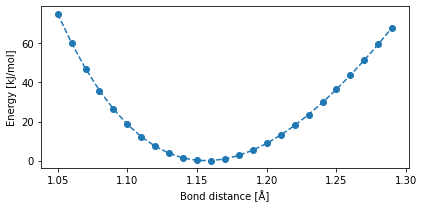

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [32]:
plt.figure(figsize=(6,3))
plt.plot(bond_l, bond_e, 'o--')
plt.xlabel('Bond distance [Å]')
plt.ylabel('Energy [kJ/mol]')
plt.tight_layout()
plt.show()

viewer = p3d.view(width=400, height=200)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModelsAsFrames(bond_xyz)
viewer.animate({"loop": "forward"})
viewer.setStyle({"stick": {}})
viewer.show()

### Harmonic fit

This will now be fitted using the using three different approaches:

1. Using the full energy curve calculated above
2. Using a symmetric distance interval around the minima
3. Using an interval from the same energies

l_0 / k_s from fit #1: 1.167 / 9888.5
l_0 / k_s from fit #2: 1.157 / 10094.0
l_0 / k_s from fit #3: 1.158 / 10536.4
B3LYP bond distance: 1.160 Å


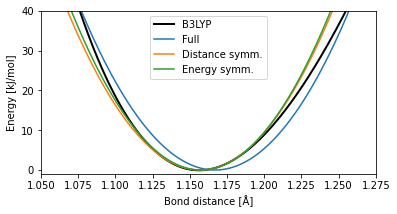

In [7]:
# function to be fitted to
def harm_func(l, l0, ks):
    return (ks / 2.0) * (l - l0) ** 2

# feed with equilibrium distance and a stiff force constant
# fitting for full curve
opt_harm1 = curve_fit(harm_func, bond_l, bond_e, [bond_l[bond_indx], 1000])
print(
    "l_0 / k_s from fit #1: {:04.3f} / {:06.1f}".format(
        opt_harm1[0][0], opt_harm1[0][1]
    )
)

# fitting for minima +/-0.025 Å
for i in np.arange(len(bond_l)):
    if bond_l[i] < bond_l[bond_indx] - 0.025:
        i_min_d = i
    if bond_l[i] < bond_l[bond_indx] + 0.025:
        i_max_d = i + 1
opt_harm2 = curve_fit(
    harm_func, bond_l[i_min_d:i_max_d], bond_e[i_min_d:i_max_d], [bond_l[bond_indx], 1000]
)
print(
    "l_0 / k_s from fit #2: {:04.3f} / {:06.1f}".format(
        opt_harm2[0][0], opt_harm2[0][1]
    )
)

# fitting for minima +10 kJ/mol
for i in np.arange(len(bond_e)):
    if (bond_e[i] > 10.0) and (i < bond_indx):
        i_min_e = i
    if (bond_e[i] < 10.0) and (i > bond_indx):
        i_max_e = i
opt_harm3 = curve_fit(
    harm_func, bond_l[i_min_e:i_max_e], bond_e[i_min_e:i_max_e], [bond_l[bond_indx], 1000]
)
print(
    "l_0 / k_s from fit #3: {:04.3f} / {:06.1f}".format(
        opt_harm3[0][0], opt_harm3[0][1]
    )
)
print("B3LYP bond distance: {:04.3f} Å".format(bond_l[bond_indx]))

plt.figure(figsize=(6, 3))
x = np.arange(1.06, 1.29, 0.001)
y = interp1d(bond_l, bond_e, kind="cubic")
plt.plot(x, y(x), "k-", lw=2.0) # plot spline B3LYP results
plt.plot(x, harm_func(x, opt_harm1[0][0], opt_harm1[0][1]))
plt.plot(x, harm_func(x, opt_harm2[0][0], opt_harm2[0][1]))
plt.plot(x, harm_func(x, opt_harm3[0][0], opt_harm3[0][1]))
plt.ylim(-1, 40)
plt.xlim((1.05, 1.275))
plt.legend(("B3LYP", "Full", "Distance symm.", "Energy symm."))
plt.xlabel("Bond distance [Å]")
plt.ylabel("Energy [kJ/mol]")
plt.show()

It is clear that using the full SCF curve we calculated yield unrealistic fits, as it puts weight on parts of the PES that will no be sampled by most dynamics. Using fits with intervals symmetric in either energy or bond distance yield similar results, especially within the region of most interest ($<10$ kJ/mol).

### Anharmonic fit

Generally, contracting a bond produces a steeper rise in energy than stretching it. This is accounted for in some force fields, such as MM3, which introduce anharmonicity into the bond energy expression by including higher order terms based on the [Morse potential]. The MM3 bond stretching term has the form

$$
{E_\mathrm{s}} = \frac{k_\text{s}}{2} (l - l_0)^2 \left( 1 - \alpha (l - l_0) + \alpha \frac{7}{12} (l - l_0)^2 \right)
$$

where $\alpha$ is derived as 2.55 from the Morse potential, but could be taken as an additional parameter. Performing curve fits for $l_0$, $k_s$, and $\alpha$ yield:

l_0 / k_s / alpha from fit #1: 1.157 / 10480.0 / 2.234
l_0 / k_s / alpha from fit #2: 1.156 / 10026.5 / 2.747
l_0 / k_s / alpha from fit #3: 1.156 / 10181.5 / 2.671


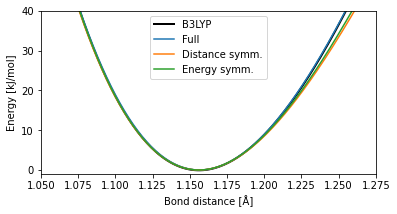

In [9]:
def anharm_func(l, l0, ks, a):
    return (
        (ks / 2.0)
        * (l - l0) ** 2
        * (1 - a * (l - l0) + a * ((7.0 / 12.0) * (l - l0) ** 2))
    )

# feed with equilibrium distance, a stiff force constant, and a=2.55
# fitting for full curve
opt_anharm1 = curve_fit(anharm_func, bond_l, bond_e, [bond_l[bond_indx], 1000, 2.55])
print(
    "l_0 / k_s / alpha from fit #1: {:04.3f} / {:06.1f} / {:04.3f}".format(
        opt_anharm1[0][0], opt_anharm1[0][1], opt_anharm1[0][2]
    )
)

opt_anharm2 = curve_fit(
    anharm_func, bond_l[i_min_d:i_max_d], bond_e[i_min_d:i_max_d], [bond_l[bond_indx], 1000, 2.55]
)
print(
    "l_0 / k_s / alpha from fit #2: {:04.3f} / {:06.1f} / {:04.3f}".format(
        opt_anharm2[0][0], opt_anharm2[0][1], opt_anharm2[0][2]
    )
)

opt_anharm3 = curve_fit(
    anharm_func, bond_l[i_min_e:i_max_e], bond_e[i_min_e:i_max_e], [bond_l[bond_indx], 1000, 2.55]
)
print(
    "l_0 / k_s / alpha from fit #3: {:04.3f} / {:06.1f} / {:04.3f}".format(
        opt_anharm3[0][0], opt_anharm3[0][1], opt_anharm3[0][2]
    )
)

plt.figure(figsize=(6, 3))
plt.plot(x, y(x), "k-", lw=2.0) # plot spline B3LYP results
plt.plot(x, anharm_func(x, opt_anharm1[0][0], opt_anharm1[0][1], opt_anharm1[0][2]))
plt.plot(x, anharm_func(x, opt_anharm2[0][0], opt_anharm2[0][1], opt_anharm2[0][2]))
plt.plot(x, anharm_func(x, opt_anharm3[0][0], opt_anharm3[0][1], opt_anharm3[0][2]))
plt.ylim(-1, 40)
plt.xlim((1.05, 1.275))
plt.legend(("B3LYP", "Full", "Distance symm.", "Energy symm."))
plt.xlabel("Bond distance [Å]")
plt.ylabel("Energy [kJ/mol]")
plt.show()

Comparing anharmonic and harmonic fits (fitted with energy-symmetric), as well as **using force constant**:

```{note}
Calculation of force constant is to be added.
```

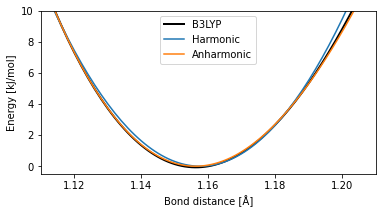

In [10]:
plt.figure(figsize=(6, 3))
plt.plot(x, y(x), "k-", lw=2.0) # plot spline B3LYP results
plt.plot(x, harm_func(x, opt_harm3[0][0], opt_harm3[0][1]))
plt.plot(x, anharm_func(x, opt_anharm3[0][0], opt_anharm3[0][1], opt_anharm3[0][2]))
plt.ylim(-0.5, 10.0)
plt.xlim((1.11, 1.21))
plt.legend(("B3LYP", "Harmonic", "Anharmonic"))
plt.xlabel("Bond distance [Å]")
plt.ylabel("Energy [kJ/mol]")
plt.show()

## Angle bending

Same as for bond stretching, distorting an angle formed between two atoms bound to a common third atom from its equilibrium causes the energy of the system to rise. This too is commonly approximated by a harmonic oscillator of the form

$$
{E_\theta} = \frac{k_\theta}{2} (\theta - \theta_0)^2
$$

where $k_\theta$ is a force constant, $\theta$ is the angle formed by the atoms and $\theta_0$ is the equilibrium angle. 


```{figure} ../../img/md/MM_bend.svg
---
width: 300px
name: fig_MM_bend
---
Angle bending.
```

We do the fitting for the bond angle of water. As a scan creates output files which are then to be read, we instead "scan" one angle at a time and save the results:

```python
# Set up the molecule and basis set
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(water_xyz)
bas_vlx = vlx.MolecularBasis.read(mol_vlx, "6-31G")

scf_settings = {}
method_settings = {}
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(mol_vlx, bas_vlx)

# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

angle_a = np.arange(60,180,5)
angle_e = []
angle_xyz = []
for angle in angle_a:
    angle_scan = "angle 2 1 3 {} {} 1".format(angle,angle) 
    opt_drv.constraints = ["$scan", angle_scan]

    # Run the scan
    opt_molecule = opt_drv.compute(mol_vlx, bas_vlx)
    angle_xyz.append(opt_molecule.get_coordinates())
    angle_e.append(scf_drv.get_scf_energy())

# index for minimal energy
angle_indx = angle_e.index(min(angle_e))
# convert to kJ/mol and shift to zero
angle_e = 2600.0 * (np.array(angle_e) - min(angle_e))
```

In [25]:
angle_a = np.array([ 60,  65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120,
       125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175])
angle_e = np.array([211.00324999, 172.29960392, 136.95217525, 105.32217088,
        77.68886893,  54.24139966,  35.07528698,  20.19335996,
         9.51034734,   2.85954049,   0.        ,   0.62314875,
         4.35827078,  10.7772227 ,  19.39917034,  29.69655521,
        41.10383384,  53.03030695,  64.87782209,  76.06299499,
        86.0421943 ,  94.33640464, 100.55286098, 104.40129606])
angle_indx = 10
angle_xyz = [np.array([[ 1.48273235e-09, -3.99610221e-09,  5.81112385e-01],
        [-9.53217005e-01, -4.23676269e-09, -1.06990790e+00],
        [ 9.53217004e-01, -4.84793520e-09, -1.06990790e+00]]),
 np.array([[ 2.98188506e-09, -3.09632552e-09,  5.40139868e-01],
        [-1.01266348e+00, -5.18974867e-09, -1.04942340e+00],
        [ 1.01266348e+00, -4.82070380e-09, -1.04942340e+00]]),
 np.array([[ 2.22857585e-09,  5.90467139e-10,  5.00561940e-01],
        [-1.07145537e+00, -9.21719742e-10, -1.02963491e+00],
        [ 1.07145537e+00,  3.36524770e-09, -1.02963491e+00]]),
 np.array([[-1.56027803e-09, -1.43286734e-09,  4.61298176e-01],
        [-1.12896936e+00, -1.17313498e-09, -1.01000335e+00],
        [ 1.12896936e+00, -3.11816129e-09, -1.01000334e+00]]),
 np.array([[ 1.89650914e-10, -4.08147468e-10,  4.21733542e-01],
        [-1.18477072e+00, -1.17776550e-09, -9.90221219e-01],
        [ 1.18477072e+00,  3.09106251e-09, -9.90221216e-01]]),
 np.array([[ 1.31555423e-09, -4.15758753e-10,  3.81523815e-01],
        [-1.23854985e+00, -1.99079098e-10, -9.70116158e-01],
        [ 1.23854984e+00, -2.58849589e-09, -9.70116170e-01]]),
 np.array([[ 7.17742013e-10,  2.98088630e-09,  3.40468762e-01],
        [-1.29005806e+00,  2.69585658e-09, -9.49589305e-01],
        [ 1.29005807e+00,  2.38485791e-09, -9.49589304e-01]]),
 np.array([[ 2.26678460e-09, -3.36757722e-09,  2.98555301e-01],
        [-1.33924067e+00, -2.18619195e-09, -9.28632677e-01],
        [ 1.33924068e+00, -4.83999169e-09, -9.28632673e-01]]),
 np.array([[-2.27965068e-09,  1.05500290e-09,  2.55716386e-01],
        [-1.38592573e+00,  2.62266688e-10, -9.07213386e-01],
        [ 1.38592573e+00,  6.17822683e-10, -9.07213383e-01]]),
 np.array([[ 4.23858037e-10, -7.19852286e-10,  2.11949498e-01],
        [-1.43000306e+00, -2.91458810e-09, -8.85330441e-01],
        [ 1.43000306e+00,  1.48452304e-09, -8.85330439e-01]]),
 np.array([[-2.42063004e-09,  4.02286541e-09,  1.67330909e-01],
        [-1.47149525e+00,  3.34218524e-09, -8.63021160e-01],
        [ 1.47149525e+00,  2.61663550e-09, -8.63021154e-01]]),
 np.array([[ 9.84619265e-11, -5.00111606e-10,  1.21847196e-01],
        [-1.51023662e+00,  2.23833331e-09, -8.40279640e-01],
        [ 1.51023662e+00, -3.55197901e-09, -8.40279645e-01]]),
 np.array([[ 8.25468075e-10, -2.53585232e-09,  7.55539917e-02],
        [-1.54618002e+00, -4.70897110e-10, -8.17133455e-01],
        [ 1.54618002e+00, -2.62845168e-09, -8.17133458e-01]]),
 np.array([[-5.02475746e-10, -3.96362902e-09,  2.84806317e-02],
        [-1.57919775e+00,  4.58085510e-10, -7.93597688e-01],
        [ 1.57919775e+00, -7.78424954e-09, -7.93597682e-01]]),
 np.array([[-4.84417324e-10, -1.64612104e-09, -1.92839560e-02],
        [-1.60930606e+00, -6.33232188e-09, -7.69715700e-01],
        [ 1.60930606e+00,  3.38825990e-09, -7.69715695e-01]]),
 np.array([[ 1.48715152e-09, -7.30424165e-10, -6.76880073e-02],
        [-1.63641695e+00, -7.23751773e-10, -7.45514105e-01],
        [ 1.63641696e+00, -6.76157904e-10, -7.45514103e-01]]),
 np.array([[ 7.41038132e-10, -3.79548516e-09, -1.16659305e-01],
        [-1.66049154e+00, -3.98600249e-09, -7.21028797e-01],
        [ 1.66049154e+00, -4.33126678e-09, -7.21028801e-01]]),
 np.array([[ 8.07486831e-10,  4.97088445e-10, -1.66117673e-01],
        [-1.68152298e+00, -4.54322219e-09, -6.96299833e-01],
        [ 1.68152298e+00,  5.77558380e-09, -6.96299831e-01]]),
 np.array([[ 1.18601449e-09, -1.55223881e-09, -2.15979915e-01],
        [-1.69953435e+00, -1.98619391e-09, -6.71368768e-01],
        [ 1.69953435e+00, -1.13032340e-09, -6.71368773e-01]]),
 np.array([[-7.14974742e-10,  2.28680800e-09, -2.66164355e-01],
        [-1.71457482e+00,  1.86480890e-10, -6.46276440e-01],
        [ 1.71457482e+00,  4.17867048e-09, -6.46276443e-01]]),
 np.array([[-1.39298405e-09,  1.15782552e-09, -3.16595166e-01],
        [-1.72671016e+00, -2.22893148e-09, -6.21060755e-01],
        [ 1.72671016e+00,  4.49320331e-09, -6.21060755e-01]]),
 np.array([[-1.17393239e-09, -3.30588609e-10, -3.67205349e-01],
        [-1.73600887e+00, -7.74292246e-10, -5.95755249e-01],
        [ 1.73600886e+00,  1.89870851e-10, -5.95755256e-01]]),
 np.array([[-3.73135178e-09, -9.47676707e-10, -4.17937415e-01],
        [-1.74252629e+00, -3.93643413e-09, -5.70388711e-01],
        [ 1.74252628e+00,  2.04568107e-09, -5.70388711e-01]]),
 np.array([[ 6.55712517e-10,  6.13839641e-10, -4.68741684e-01],
        [-1.74628235e+00, -3.37425205e-09, -5.44986015e-01],
        [ 1.74628236e+00,  4.59640776e-09, -5.44986022e-01]])]

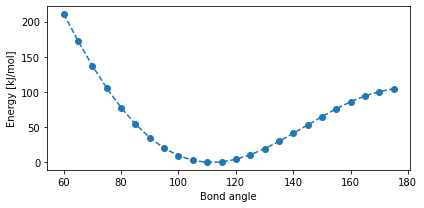

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
plt.figure(figsize=(6,3))
plt.plot(angle_a, angle_e, 'o--')
plt.xlabel('Bond angle')
plt.ylabel('Energy [kJ/mol]')
plt.tight_layout()
plt.show()


angle_struct = ''
b2a =  0.5291772
for i in np.arange(len(angle_a)):
    angle_struct += '3\n*\n'
    angle_struct += 'O ' + str(np.around(b2a*angle_xyz[i][0][0],5)) + ' ' + str(np.around(b2a*angle_xyz[i][0][1],5)) + ' ' + str(np.around(b2a*angle_xyz[i][0][2],5)) + '\n'
    angle_struct += 'H ' + str(np.around(b2a*angle_xyz[i][1][0],5)) + ' ' + str(np.around(b2a*angle_xyz[i][1][1],5)) + ' ' + str(np.around(b2a*angle_xyz[i][1][2],5)) + '\n'
    angle_struct += 'H ' + str(np.around(b2a*angle_xyz[i][2][0],5)) + ' ' + str(np.around(b2a*angle_xyz[i][2][1],5)) + ' ' + str(np.around(b2a*angle_xyz[i][2][2],5)) + '\n'

viewer = p3d.view(width=400, height=200)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModelsAsFrames(angle_struct)
viewer.animate({"loop": "forward"})
viewer.setStyle({"stick": {}})
viewer.rotate(-90, "x")
viewer.show()

### Harmonic fit

Fitting with a harmonic function, focusing on an interval with equal energy end-points:

l_0 / k_s from fit: 112.149 / 0.134355
B3LYP angle: 110.0


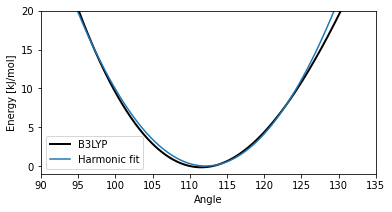

In [47]:
# fitting for minima +20 kJ/mol
for i in np.arange(len(angle_e)):
    if (angle_e[i] > 20.0) and (i < angle_indx):
        i_min_a = i
    if (angle_e[i] < 20.0) and (i > angle_indx):
        i_max_a = i
opt_harm_angle = curve_fit(
    harm_func, angle_a[i_min_a:i_max_a], angle_e[i_min_a:i_max_a]
)
print(
    "l_0 / k_s from fit: {:04.3f} / {:7f}".format(
        opt_harm_angle[0][0], opt_harm_angle[0][1]
    )
)
print("B3LYP angle: {:04.1f}".format(angle_a[angle_indx]))

plt.figure(figsize=(6, 3))
x = np.arange(75,150, 0.1)
y = interp1d(angle_a, angle_e, kind="cubic")
plt.plot(x, y(x), "k-", lw=2.0) # plot spline B3LYP results
plt.plot(x, harm_func(x, opt_harm_angle[0][0], opt_harm_angle[0][1]))
plt.ylim(-1,20)
plt.xlim((90,135))
plt.legend(("B3LYP", "Harmonic fit"))
plt.xlabel("Angle")
plt.ylabel("Energy [kJ/mol]")
plt.show()

The real angle bending interaction is clearly not a harmonic oscillator, as exemplified by the potential energy curve in below Figure, showing the change in energy when distorting the H--O--H angle found in water. Compressing the angle causes the two hydrogen atoms to come close together, leading to a steep curve near $\theta = 0^\circ$, while increasing the angle leads to a cusp at $\theta = 180^\circ$ due to symmetry. Again, some force fields account for this anharmonicity with additional terms, such as the MM3 angle bending term:
%
\begin{equation*}
\begin{split}
{E_\theta} = \frac{k_\theta}{2} (\theta - \theta_0)^2 \bigl( 1 &- \alpha (\theta - \theta_0) + \beta (\theta - \theta_0)^2  \\
 & - \gamma (\theta - \theta_0)^3 + \delta (\theta - \theta_0)^4 \bigr)
\end{split}
\end{equation*} 
%
where the constants have been fitted to experimental data but are the same for all bending interactions. This gives a better agreement with the actual angle bending behaviour, as seen in Figure below, but again, for lower temperatures the harmonic oscillator is still a valid and computationally efficient approximation.

This gives a better agreement with the actual angle bending behaviour, as seen in Figure below, but again, for lower temperatures the harmonic oscillator is still a valid and computationally efficient approximation.


```{figure} ../../img/md/MM_waterbend_even.svg
---
width: 300px
name: fig_MM_waterbend_even
---
Potential energy curves for distortion of the water angle. The reference *ab initio* energy was calculated at the MP2/cc-pVTZ level of theory while the other curves were derived from the harmonic oscillator used in CHARMM and the anharmonic expression used in MM3.
```

## Torsion

When two atoms are bonded to atoms on opposite sides of a central bond, as for the opposing hydrogen atoms in ethane, then twisting these around the central bond can cause a change in the potential energy. The torsional energy is thus a function of the dihedral angle, $\omega$, formed between the first and fourth atom, while looking through the bond between the second and third atoms. For a visualization of this, see Figure. The torsion energy term is usually expressed in terms of a Fourier expansion of the form

$$
{E_\omega} = k_\omega \left(1 + \cos(n\omega -\delta)\right)
$$

where $k_\omega$ is a force constant, $n$ is the periodicity and $\delta$ is a phase shift. Typically, several such terms are included for each set of four atoms in order to combine different multiplicities. The MM3 force field always includes terms of multiplicity 1, 2 and 3, with $\delta$ set to zero for each, while the CHARMM force field allows a more varied combination of terms.

Figure shows the potential energy curve when twisting butane around the central carbon--carbon bond. The two identical lower peaks represent the conformations when the one hydrogen atom on each side is eclipsed by the carbon atom on the other side, while the main peak comes from the conformation when all atoms are eclipsed by an equivalent atom on the other side. It should be noted that the torsional energy of the force field does not come from a single interaction in this case, but nine. One for the two carbon atoms, four for the carbon atoms meeting the hydrogen atoms on the other side and four for  the combinations of hydrogen atoms on opposite sides. It is easy to see that torsional interactions can quickly become very complicated when there are many atom types involved. This is further complicated by the fact that most force field also include non-bonded interactions between atoms separated by more than two bonds, meaning that the true rotational barrier will be a sum of all torsional and non-bonded interactions. 

The conformation of a molecule is defined by its current dihedral angles, with two identifiable conformations for butane visible as minima in below Figure: the global minimum at 180 degrees and two identical minima at $\pm70$ degrees. For calculations where both the conformations themselves as well as the transitions between them are important, it is necessary to recreate the full potential energy curve and not just focus on the regions around the minima, as was done for bond stretching and angle bending terms. 


```{figure} ../../img/md/MM_torsion.svg
---
width: 300px
name: fig_MM_torsion
---
Torsion.
```


```{figure} ../../img/md/MM_butanetorsion_even.svg
---
width: 300px
name: fig_MM_butanetorsion_even
---
Potential energy curves for the torsional barrier found when twisting butane around the central bond. The reference *ab initio* energy was calculated at the MP2/cc-pVTZ level of theory while the MM curve was obtained as a least squares fit with multiplicities 1, 2, 3, 4 and 5.
```



```python
# Set up the molecule and basis set
ethane_xyz = """
C       0.0000000000     0.0000000000     0.7616375820
C       0.0000000000     0.0000000000    -0.7616375820
H       1.0145603421     0.0000000000     1.1557300969
H      -0.5072801711    -0.8786350299     1.1557300969
H      -0.5072801711     0.8786350299     1.1557300969
H       0.5072801711    -0.8786350299    -1.1557300969
H       0.5072801711     0.8786350299    -1.1557300969
H      -1.0145603421    -0.0000000000    -1.1557300969
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_str(ethane_xyz)
bas_vlx = vlx.MolecularBasis.read(mol_vlx, "STO-3G")

scf_settings = {}
method_settings = {}
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(mol_vlx, bas_vlx)

# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

dihed_a = np.arange(0,65,2.5)
dihed_e = []
dihed_xyz = []
for dihedral in dihed_a:
    dihedral_scan = "dihedral 3 1 2 6 {} {} 1".format(dihedral,dihedral) 
    opt_drv.constraints = ["$scan", dihedral_scan]

    # Run the scan
    opt_molecule = opt_drv.compute(mol_vlx, bas_vlx)
    dihed_xyz.append(opt_molecule.get_coordinates())
    dihed_e.append(scf_drv.get_scf_energy())

# index for minimal energy
dihed_indx = dihed_e.index(min(dihed_e))
# convert to kJ/mol and shift to zero
dihed_e = 2600.0 * (np.array(dihed_e) - min(dihed_e))

```

In [70]:
dihed_a = np.array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
       27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
       55. , 57.5, 60. , 62.5])
dihed_e = np.array([11.42688953, 11.37403123, 11.21724467, 10.95983752, 10.60722575,
       10.16671466,  9.64639677,  9.05835728,  8.41325502,  7.72335593,
        7.00143352,  6.26049586,  5.51353275,  4.77208048,  4.05098902,
        3.36060175,  2.71183578,  2.11472561,  1.57755804,  1.1100636 ,
        0.71808092,  0.40692622,  0.18165335,  0.04545572,  0.        ,
        0.0454559 ])
dihed_indx = 24
dihed_xyz = [np.array([[ 3.70141663e-05,  2.62182715e-05,  1.45666102e+00],
        [-3.77412933e-05, -8.13291733e-05, -1.45666095e+00],
        [ 1.64881376e+00, -9.51706330e-01,  2.21091471e+00],
        [-1.64846839e+00, -9.52181362e-01,  2.21093194e+00],
        [-3.42094104e-04,  1.90376468e+00,  2.21091779e+00],
        [ 1.64857344e+00, -9.52089282e-01, -2.21092898e+00],
        [ 3.36787148e-04,  1.90367362e+00, -2.21092351e+00],
        [-1.64891552e+00, -9.51622315e-01, -2.21091175e+00]]),
 np.array([[ 7.67930773e-04,  1.38162863e-03,  1.45659471e+00],
        [-8.52366217e-04, -1.39713433e-03, -1.45659472e+00],
        [ 1.67034953e+00, -9.13489635e-01,  2.21071154e+00],
        [-1.62344007e+00, -9.92111330e-01,  2.21096164e+00],
        [-4.74790940e-02,  1.90436116e+00,  2.21065209e+00],
        [ 1.62623721e+00, -9.89852561e-01, -2.21072974e+00],
        [ 4.74236644e-02,  1.90195922e+00, -2.21095176e+00],
        [-1.67300831e+00, -9.11103049e-01, -2.21064381e+00]]),
 np.array([[ 1.44543780e-03,  2.87192573e-03,  1.45642975e+00],
        [-1.80128385e-03, -2.72039986e-03, -1.45642971e+00],
        [ 1.69111080e+00, -8.74692889e-01,  2.21020162e+00],
        [-1.59728155e+00, -1.03158819e+00,  2.21075159e+00],
        [-9.48799205e-02,  1.90390289e+00,  2.21034761e+00],
        [ 1.60302114e+00, -1.02722167e+00, -2.21022214e+00],
        [ 9.46929350e-02,  1.89905291e+00, -2.21074097e+00],
        [-1.69630980e+00, -8.69814527e-01, -2.21033760e+00]]),
 np.array([[ 1.96492240e-03,  4.25259791e-03,  1.45615479e+00],
        [-2.73880253e-03, -3.85912651e-03, -1.45615474e+00],
        [ 1.71093170e+00, -8.35690811e-01,  2.20935327e+00],
        [-1.57060700e+00, -1.07008973e+00,  2.21037403e+00],
        [-1.41775255e-01,  1.90221900e+00,  2.20982251e+00],
        [ 1.57915242e+00, -1.06388603e+00, -2.20937660e+00],
        [ 1.41370781e-01,  1.89520503e+00, -2.21036262e+00],
        [-1.71830179e+00, -8.28358088e-01, -2.20981045e+00]]),
 np.array([[ 0.00236531,  0.00559803,  1.45577047],
        [-0.00370417, -0.00487571, -1.45577061],
        [ 1.72986435, -0.79638826,  2.20818015],
        [-1.54326501, -1.10775648,  2.20976811],
        [-0.18835051,  1.89940518,  2.20914898],
        [ 1.55458071, -1.09993005, -2.20820604],
        [ 0.18766068,  1.89036304, -2.20975642],
        [-1.73915385, -0.78661263, -2.20913521]]),
 np.array([[ 0.00263702,  0.00685738,  1.45529674],
        [-0.00465952, -0.00573805, -1.4552967 ],
        [ 1.74786942, -0.75686658,  2.20673852],
        [-1.51541079, -1.14446322,  2.2089714 ],
        [-0.23440687,  1.89545447,  2.20835631],
        [ 1.5293552 , -1.13528062, -2.20676665],
        [ 0.23337516,  1.8845972 , -2.20895917],
        [-1.75876211, -0.7447483 , -2.20834036]]),
 np.array([[ 0.00278126,  0.00801081,  1.45474003],
        [-0.0055846 , -0.00643543, -1.45474002],
        [ 1.76495907, -0.71710586,  2.20506083],
        [-1.48708941, -1.18021143,  2.2079807 ],
        [-0.27990583,  1.89039358,  2.20746942],
        [ 1.50346779, -1.16995662, -2.20508985],
        [ 0.2784959 ,  1.87794885, -2.2079688 ],
        [-1.77712741, -0.70281031, -2.20745236]]),
 np.array([[ 0.00280944,  0.00901622,  1.45412379],
        [-0.00644129, -0.00696013, -1.45412377],
        [ 1.78106562, -0.67729538,  2.20320678],
        [-1.45850583, -1.21484319,  2.20684771],
        [-0.32459547,  1.88425601,  2.20648067],
        [ 1.47704366, -1.20380782, -2.20323744],
        [ 0.32277883,  1.87051352, -2.20683587],
        [-1.79415771, -0.66103654, -2.20646191]]),
 np.array([[ 0.00273085,  0.00986196,  1.45345763],
        [-0.0072129 , -0.00731249, -1.45345754],
        [ 1.79621296, -0.63739955,  2.20121995],
        [-1.42968214, -1.24839713,  2.20557682],
        [-0.36847739,  1.87708524,  2.20541848],
        [ 1.45006623, -1.23687105, -2.20125198],
        [ 0.36624871,  1.86233133, -2.20556512],
        [-1.80988912, -0.61944563, -2.20539806]]),
 np.array([[ 0.00255978,  0.01053171,  1.45275614],
        [-0.0078783 , -0.00749688, -1.45275604],
        [ 1.8103986 , -0.59745041,  2.19915252],
        [-1.40068526, -1.28086522,  2.20419164],
        [-0.41149291,  1.86892673,  2.20429781],
        [ 1.42256185, -1.26912826, -2.19918581],
        [ 0.40886495,  1.85345607, -2.20418025],
        [-1.82433183, -0.57811131, -2.20427583]]),
 np.array([[ 0.00230977,  0.01099805,  1.45203566],
        [-0.00840832, -0.00751196, -1.45203562],
        [ 1.82361515, -0.55749555,  2.19706393],
        [-1.37160967, -1.31222739,  2.20272939],
        [-0.45355531,  1.85982453,  2.20312501],
        [ 1.39456639, -1.30054956, -2.1970995 ],
        [ 0.45056101,  1.84395916, -2.20271817],
        [-1.83748236, -0.53713124, -2.20310082]]),
 np.array([[ 2.00566019e-03,  1.12824778e-02,  1.45130606e+00],
        [-8.80650253e-03, -7.38851647e-03, -1.45130590e+00],
        [ 1.83588189e+00, -5.17515352e-01,  2.19499430e+00],
        [-1.34242614e+00, -1.34253901e+00,  2.20118127e+00],
        [-4.94719381e-01,  1.84983994e+00,  2.20192990e+00],
        [ 1.36607567e+00, -1.33116062e+00, -2.19503088e+00],
        [ 4.91403167e-01,  1.83384393e+00, -2.20117040e+00],
        [-1.84941787e+00, -4.96487281e-01, -2.20190403e+00]]),
 np.array([[ 1.66094369e-03,  1.13749571e-02,  1.45058224e+00],
        [-9.05612003e-03, -7.13298376e-03, -1.45058223e+00],
        [ 1.84719379e+00, -4.77535522e-01,  2.19299657e+00],
        [-1.31317236e+00, -1.37182529e+00,  2.19960946e+00],
        [-5.34976777e-01,  1.83900478e+00,  2.20070404e+00],
        [ 1.33711097e+00, -1.36094441e+00, -2.19303208e+00],
        [ 5.31396332e-01,  1.82315555e+00, -2.19959982e+00],
        [-1.86016009e+00, -4.56202343e-01, -2.20067844e+00]]),
 np.array([[ 1.29659625e-03,  1.12682913e-02,  1.44987457e+00],
        [-9.14635333e-03, -6.76228873e-03, -1.44987449e+00],
        [ 1.85757618e+00, -4.37510184e-01,  2.19111278e+00],
        [-1.28383321e+00, -1.40014640e+00,  2.19802259e+00],
        [-5.74366324e-01,  1.82734723e+00,  2.19946099e+00],
        [ 1.30763813e+00, -1.38994657e+00, -2.19114969e+00],
        [ 5.70591782e-01,  1.81190987e+00, -2.19801334e+00],
        [-1.86976029e+00, -4.16258996e-01, -2.19943345e+00]]),
 np.array([[ 9.31102129e-04,  1.09679513e-02,  1.44919652e+00],
        [-9.07030962e-03, -6.29391883e-03, -1.44919647e+00],
        [ 1.86699819e+00, -3.97583306e-01,  2.18939319e+00],
        [-1.25451542e+00, -1.42743950e+00,  2.19645381e+00],
        [-6.12772910e-01,  1.81494872e+00,  2.19820992e+00],
        [ 1.27776918e+00, -1.41806778e+00, -2.18943240e+00],
        [ 6.08885080e-01,  1.80016870e+00, -2.19644493e+00],
        [-1.87822849e+00, -3.76796438e-01, -2.19817983e+00]]),
 np.array([[ 5.80143616e-04,  1.04820526e-02,  1.44855647e+00],
        [-8.82466550e-03, -5.74480812e-03, -1.44855637e+00],
        [ 1.87548417e+00, -3.57687161e-01,  2.18787328e+00],
        [-1.22516408e+00, -1.45379197e+00,  2.19492457e+00],
        [-6.50296072e-01,  1.80182662e+00,  2.19695376e+00],
        [ 1.24746081e+00, -1.44536287e+00, -2.18791323e+00],
        [ 6.46382889e-01,  1.78792833e+00, -2.19491635e+00],
        [-1.88562622e+00, -3.37736694e-01, -2.19692216e+00]]),
 np.array([[ 2.60286799e-04,  9.81948109e-03,  1.44796288e+00],
        [-8.41105281e-03, -5.13441680e-03, -1.44796267e+00],
        [ 1.88304175e+00, -3.17825042e-01,  2.18658394e+00],
        [-1.19576537e+00, -1.47924303e+00,  2.19345973e+00],
        [-6.86969018e-01,  1.78801182e+00,  2.19569788e+00],
        [ 1.21671691e+00, -1.47183692e+00, -2.18662508e+00],
        [ 6.83122955e-01,  1.77519620e+00, -2.19345205e+00],
        [-1.89199970e+00, -2.99066933e-01, -2.19566422e+00]]),
 np.array([[-1.49408856e-05,  8.99265022e-03,  1.44742288e+00],
        [-7.83211958e-03, -4.48050152e-03, -1.44742280e+00],
        [ 1.88967623e+00, -2.77997546e-01,  2.18555214e+00],
        [-1.16630011e+00, -1.50383096e+00,  2.19208137e+00],
        [-7.22832953e-01,  1.77353134e+00,  2.19444696e+00],
        [ 1.18554235e+00, -1.49749443e+00, -2.18559387e+00],
        [ 7.19149954e-01,  1.76197469e+00, -2.19207466e+00],
        [-1.89739115e+00, -2.60764938e-01, -2.19441212e+00]]),
 np.array([[-2.35179273e-04,  8.01503738e-03,  1.44694221e+00],
        [-7.09187678e-03, -3.79893745e-03, -1.44694218e+00],
        [ 1.89539940e+00, -2.38142823e-01,  2.18479883e+00],
        [-1.13669883e+00, -1.52762800e+00,  2.19080850e+00],
        [-7.57987434e-01,  1.75838428e+00,  2.19320402e+00],
        [ 1.15389280e+00, -1.52237736e+00, -2.18483754e+00],
        [ 7.54564829e-01,  1.74823895e+00, -2.19080312e+00],
        [-1.90184611e+00, -2.22744625e-01, -2.19317095e+00]]),
 np.array([[-3.86986816e-04,  6.90400463e-03,  1.44652776e+00],
        [-6.20489818e-03, -3.11019402e-03, -1.44652771e+00],
        [ 1.90020275e+00, -1.98391734e-01,  2.18433620e+00],
        [-1.10702181e+00, -1.55059474e+00,  2.18966746e+00],
        [-7.92361263e-01,  1.74263493e+00,  2.19198133e+00],
        [ 1.12186910e+00, -1.54641136e+00, -2.18437485e+00],
        [ 7.89294185e-01,  1.73402288e+00, -2.18966293e+00],
        [-1.90539323e+00, -1.85099061e-01, -2.19194739e+00]]),
 np.array([[-4.64963317e-04,  5.67681543e-03,  1.44618289e+00],
        [-5.18010513e-03, -2.42712209e-03, -1.44618283e+00],
        [ 1.90409978e+00, -1.58669920e-01,  2.18417186e+00],
        [-1.07718181e+00, -1.57280675e+00,  2.18867304e+00],
        [-8.26070092e-01,  1.72626956e+00,  2.19078365e+00],
        [ 1.08941801e+00, -1.56964562e+00, -2.18421024e+00],
        [ 8.23451715e-01,  1.71928846e+00, -2.18866940e+00],
        [-1.90807395e+00, -1.47721324e-01, -2.19074904e+00]]),
 np.array([[-4.68678262e-04,  4.35118339e-03,  1.44591071e+00],
        [-4.02596508e-03, -1.76181243e-03, -1.44591069e+00],
        [ 1.90709145e+00, -1.18922669e-01,  2.18431249e+00],
        [-1.04710522e+00, -1.59432206e+00,  2.18783764e+00],
        [-8.59214699e-01,  1.70927258e+00,  2.18961643e+00],
        [ 1.05650232e+00, -1.59211314e+00, -2.18434187e+00],
        [ 8.57134529e-01,  1.70399616e+00, -2.18783548e+00],
        [-1.90991531e+00, -1.10520861e-01, -2.18958935e+00]]),
 np.array([[-3.86427786e-04,  2.94754198e-03,  1.44571471e+00],
        [-2.76942090e-03, -1.12930013e-03, -1.44571465e+00],
        [ 1.90918955e+00, -7.92084460e-02,  2.18474141e+00],
        [-1.01677859e+00, -1.61513677e+00,  2.18718404e+00],
        [-8.91782338e-01,  1.69166851e+00,  2.18849838e+00],
        [ 1.02315662e+00, -1.61378547e+00, -2.18477169e+00],
        [ 8.90323732e-01,  1.68814181e+00, -2.18718249e+00],
        [-1.91095428e+00, -7.35117518e-02, -2.18846960e+00]]),
 np.array([[-2.27723095e-04,  1.48942482e-03,  1.44559639e+00],
        [-1.42119097e-03, -5.38773292e-04, -1.44559637e+00],
        [ 1.91038379e+00, -3.95490758e-02,  2.18545784e+00],
        [-9.86188004e-01, -1.63526155e+00,  2.18671830e+00],
        [-9.23818470e-01,  1.67346786e+00,  2.18743789e+00],
        [ 9.89415931e-01, -1.63465230e+00, -2.18548100e+00],
        [ 9.23056677e-01,  1.67170914e+00, -2.18671769e+00],
        [-1.91120145e+00, -3.66695646e-02, -2.18741535e+00]]),
 np.array([[ 1.71653298e-06,  2.94264935e-08,  1.44552503e+00],
        [-1.73355748e-06, -8.14940998e-09, -1.44552504e+00],
        [ 1.91070326e+00, -2.55458349e-07,  2.18645939e+00],
        [-9.55347159e-01, -1.65471508e+00,  2.18646337e+00],
        [-9.55346806e-01,  1.65471533e+00,  2.18646338e+00],
        [ 9.55347225e-01, -1.65471507e+00, -2.18646336e+00],
        [ 9.55346803e-01,  1.65471529e+00, -2.18646339e+00],
        [-1.91070326e+00, -2.16292236e-07, -2.18645944e+00]]),
 np.array([[ 3.22457039e-04, -1.50130723e-03,  1.44559641e+00],
        [ 1.44514273e-03,  4.82264144e-04, -1.44559642e+00],
        [ 1.91011097e+00,  3.95420429e-02,  2.18765066e+00],
        [-9.24049057e-01, -1.67349386e+00,  2.18639974e+00],
        [-9.86419458e-01,  1.63528387e+00,  2.18556348e+00],
        [ 9.20785084e-01, -1.67395986e+00, -2.18767322e+00],
        [ 9.87237920e-01,  1.63701317e+00, -2.18640035e+00],
        [-1.90943250e+00,  3.66389731e-02, -2.18554030e+00]])]

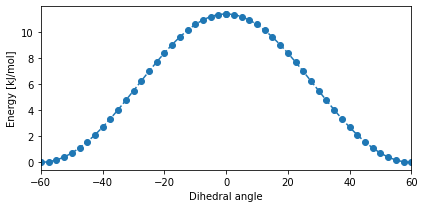

In [83]:
plt.figure(figsize=(6,3))
plt.plot(dihed_a, dihed_e,'o--',color='#1f77b4')
plt.plot(-dihed_a, dihed_e,'o--',color='#1f77b4')
plt.xlabel('Dihedral angle')
plt.ylabel('Energy [kJ/mol]')
plt.xlim((-60,60))
plt.tight_layout()
plt.show()


## Electrostatic interaction
The non-bonded force field interactions are divided into electrostatic interactions, caused by static multipoles, and van der Waals interactions, containing everything else. For most force fields, only point charges are used in the electrostatic interactions, resulting in an energy given simply by the Coulomb interaction

$$
{E_\mathrm{el}} = \frac{q_i q_j}{4\pi \epsilon_0 r_{ij}},
$$

where $q_i$ and $q_j$ are the partial charges of the interacting atoms, $r_{ij}$ is the distance between them and $\epsilon_0$ is the vacuum permittivity. It is also possible to use higher order multipoles, an example of which can be found in the MM3 force field, where dipole moments are assigned to each bonded pair. This gives the advantage of a more flexible description, as the dipoles depend on the types of both involved atoms, but requires additional parametrization and has difficulty dealing with ionic systems.

## van der Waals interaction

The van der Waals interaction is typically represented by two terms. One due to exchange interaction, causing a strong repulsion at close distances, and one that is due to London dispersion, resulting in a weak attraction at longer distances. The most commonly used form is the [Lennard-Jones potential]:

$$
{E_\mathrm{vdw}} = \epsilon \left[ \left( \frac{r_\text{min}}{r} \right)^{12} - 2 \left( \frac{r_\text{min}}{r} \right)^6 \right]
$$

\noindent where $\epsilon$ is the depth of the potential well, usually created as the mean of two parameters specific to the two interacting atom types, $r_\text{min}$ is the position of the bottom of the well and $r$ is the interatomic distance. While it is possible to motivate the use of $r^{-6}$ for the attractive part, the use of $r^{-12}$ for the repulsive part is more pragmatic in origin, having that form simply because it is the square of $r^{-6}$, making its computation highly efficient. It can be argued[cite jensen2006] that an exponential form is more realistic, such as the [Buckingham potential]used in MM3:

$$
{E_\mathrm{vdw}} = A e^{- B r} - \frac{C}{r^{-6}}
$$

where $A$, $B$, and $C$ are constants. Calculating this expression is more demanding than the Lennard-Jones (LJ) potential, but produces a repulsive force that is closer to what is found using \emph{ab initio} methods. For very short interatomic distances, however, the Buckingham potential becomes strongly attractive, which can lead to highly unphysical behaviour for systems in unfavourable starting positions.


## Additional terms
Depending on what the force field is intended for, many additional terms can be added to the potential energy function. Cross-terms are a common addition, accounting for more complex couplings between structural properties. Examples of these can be found in the MM3 force field, which contains stretch--bend, torsion--stretch and bend--bend interactions. As an example, the stretch--bend interaction accounts for the fact that compressing an angle formed by three bonded atoms will cause the repulsion between the two end atoms to increase, resulting in an elongation of their bonds to the middle atom. Another example of such structural corrections comes in the form of the out-of-plane term. If three or four atoms are bonded to a central atom with their equilibrium position in a plane, as for e.g.\ formaledehyde, the change in energy caused by a distortion of the central atom out of the plane is hard to model by just angle bending terms, as the individual angle distortions are small. The out-of-plane term instead depends on the angles formed between the plane and the bonds connecting the central and outer atoms. This is shown in below Figure, where the $\chi$ is an example of an out-of-plane angle. 


```{figure} ../../img/md/MM_outofplane.svg
---
width: 300px
name: fig_MM_outofplane
---
Out-of-plane bending.
```
